In [1]:
%matplotlib inline

## Label Propagation
- A case of "semi-supervised" learning, when some samples aren't labeled.
- Can be used for classification & regression.
- Kernel methods can be used to project data into alternate spaces.
- Two methods: [Label Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html#sklearn.semi_supervised.LabelPropagation), [Label Spreading](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading) 
- Both build similarity graphs over all items in the dataset, and use a *clamping effect* on label distributions to modify the weights of true ground labeled data.
- **Label Propagation** "hard clamps" the input labels (alpha = 0). Relaxing alpha to 0.2 tells the algorithm to retain 80% of the original labels.
- **Label Spreading** instead minimizes a loss function, making it more robust to noise. It normalizes edge weights using a graph Laplacian matrix.
- Label propagation uses either an **RBF** or **KNN** kernel
    - RBF builds a fully-connected, dense graph in memory. When combined with the cost of full matrix multiply math for each algorithm iteration, this can lead to very long runtimes.
    - KNN builds a sparse matrix instead with much shorter runtimes.

## Example: Label propagation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading
from sklearn.datasets import make_circles

# generate ring with inner box
n_samples    = 200
X, y         = make_circles(n_samples=n_samples, shuffle=False)
outer, inner = 0, 1
labels       = np.full(n_samples, -1.)
labels[0]    = outer
labels[-1]   = inner

label_spread = LabelSpreading(kernel='knn', alpha=0.8)
label_spread.fit(X, labels)

LabelSpreading(alpha=0.8, kernel='knn')

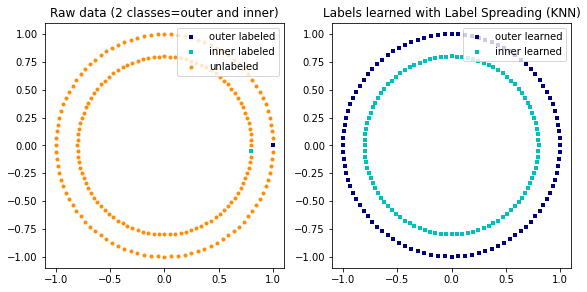

In [3]:
output_labels = label_spread.transduction_

plt.figure(figsize=(8.5, 4))
plt.subplot(1, 2, 1)

plt.scatter(X[labels == outer, 0], 
            X[labels == outer, 1], color='navy',
            marker='s', lw=0, label="outer labeled", s=10)

plt.scatter(X[labels == inner, 0], 
            X[labels == inner, 1], color='c',
            marker='s', lw=0, label='inner labeled', s=10)

plt.scatter(X[labels == -1, 0], 
            X[labels == -1, 1], color='darkorange',
            marker='.', label='unlabeled')

plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Raw data (2 classes=outer and inner)")

plt.subplot(1, 2, 2)
output_label_array = np.asarray(output_labels)
outer_numbers      = np.where(output_label_array == outer)[0]
inner_numbers      = np.where(output_label_array == inner)[0]

plt.scatter(X[outer_numbers, 0], 
            X[outer_numbers, 1], color='navy',
            marker='s', lw=0, s=10, label="outer learned")

plt.scatter(X[inner_numbers, 0], 
            X[inner_numbers, 1], color='c',
            marker='s', lw=0, s=10, label="inner learned")

plt.legend(scatterpoints=1, shadow=False, loc='upper right')
plt.title("Labels learned with Label Spreading (KNN)")

plt.subplots_adjust(left=0.07, bottom=0.07, right=0.93, top=0.92)
plt.show()

## Example: Label Propagation performance - digits dataset
- 1797 total points, only 30 labeled
- top 10 most uncertain predictions are shown.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import confusion_matrix, classification_report

digits           = datasets.load_digits()
rng              = np.random.RandomState(2)
indices          = np.arange(len(digits.data))
rng.shuffle(indices)
X                = digits.data[indices[:340]]
y                = digits.target[indices[:340]]
images           = digits.images[indices[:340]]
n_total_samples  = len(y)
n_labeled_points = 40
indices          = np.arange(n_total_samples)
unlabeled_set    = indices[n_labeled_points:]

# Shuffle everything around
y_train = np.copy(y)
y_train[unlabeled_set] = -1

lp_model         = LabelSpreading(gamma=.25, max_iter=20)
lp_model.fit(X, y_train)
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels      = y[unlabeled_set]
cm               = confusion_matrix(true_labels, 
                                    predicted_labels, 
                                    labels=lp_model.classes_)

Label Spreading model: 40 labeled & 300 unlabeled points (340 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      1.00      0.90        37
           2       1.00      0.86      0.92        28
           3       1.00      0.80      0.89        35
           4       0.92      1.00      0.96        24
           5       0.74      0.94      0.83        34
           6       0.89      0.96      0.92        25
           7       0.94      0.89      0.91        35
           8       1.00      0.68      0.81        31
           9       0.81      0.88      0.84        24

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300

Confusion matrix
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  1 24  0  0  0  2  1  0  0]
 [ 0  0  0 28  0  5  0  1  0  1]
 [ 0  0  0  0 24  0  0 

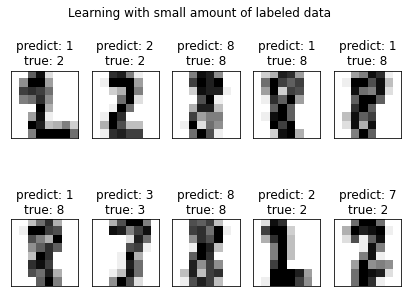

In [5]:
print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

# Calculate uncertainty values for each transduced distribution
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

f = plt.figure(figsize=(7, 5))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index]

    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('predict: %i\ntrue: %i' % (
        lp_model.transduction_[image_index], y[image_index]))

f.suptitle('Learning with small amount of labeled data')
plt.show()

## Example: Label propagation, digits dataset, active learning
- start by training model with only 10 labeled points
- pick five most uncertain points to label
- train combined (10+5) points
- repeat up to 30 points

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix

digits            = datasets.load_digits()
rng               = np.random.RandomState(0)
indices           = np.arange(len(digits.data))
rng.shuffle(indices)
X                 = digits.data[indices[:330]]
y                 = digits.target[indices[:330]]
images            = digits.images[indices[:330]]
n_total_samples   = len(y)
n_labeled_points  = 40
max_iterations    = 5
unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]

Iteration 0 ______________________________________________________________________
Label Spreading model: 40 labeled & 290 unlabeled (330 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.78      0.69      0.73        26
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        27
           4       0.92      0.96      0.94        23
           5       0.96      0.70      0.81        33
           6       0.97      0.97      0.97        35
           7       0.94      0.91      0.92        33
           8       0.62      0.89      0.74        28
           9       0.73      0.79      0.76        34

    accuracy                           0.87       290
   macro avg       0.89      0.87      0.87       290
weighted avg       0.88      0.87      0.87       290

Confusion matrix
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 18  2  0  0  0  1  0  5  0]
 [ 0  0 27  0

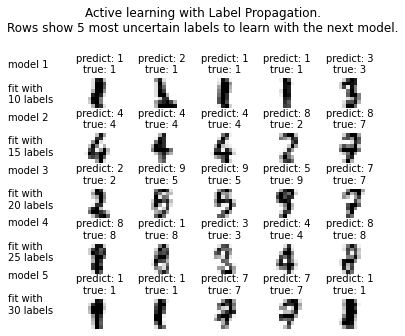

In [7]:
f = plt.figure()

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points,
             n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], y[image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.", y=1.15)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2,
                    hspace=0.85)
plt.show()